In [204]:
import sys
sys.path.append('../src/')

In [2]:
%load_ext autoreload
%autoreload 2
from inspector import load_model
from patch import patch_suppress_enhance

In [3]:
import os
import seaborn as sb
import pickle
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

from matplotlib import pyplot as plt
import numpy as np

from tqdm import tqdm

In [4]:
import seaborn as sb

In [113]:
def pred_true_labels(df, inspector):
    predicted_logits = []
    for text in df.text.to_list():
        encoded_input = inspector._prepare_inputs(text)
        output = inspector.model(**encoded_input)
        predicted_logits.append(output.logits.detach().cpu().numpy())
    predicted_labels = np.argmax(np.array(predicted_logits), axis=-1)[:, 0]
    true_labels = df.label.to_numpy()
    return predicted_labels, true_labels

In [114]:
data_path = "../data/input/"
EXPERIMENT_NAME = f"car_distance"  #car_distance_electoral_seeking
DATASET_NAME = "DAIGTV2"
BASE_MODEL_NAME = "bert-base-cased"
MODEL_DICT_ID = f"detector-{BASE_MODEL_NAME}-{DATASET_NAME}-{EXPERIMENT_NAME}"
random_state = 0
data_path

'../data/input/'

## Prepare data

In [115]:
data_input = os.path.join(data_path, "train_v2_drcat_02.csv")
daigt_df_all = pd.read_csv(data_input)

data_input = os.path.join(data_path, f"data_train_{DATASET_NAME}_{EXPERIMENT_NAME}_rs_{random_state}.json")
daigt_train = pd.read_json(data_input, orient='records', lines=True)

train_idx = []
for i, text in enumerate(daigt_train.text):
    idx = np.where(daigt_train.text==text)[0]
    if len(idx)==1:
        train_idx.append(idx[0])
    else:
        print(i)
daigt_train.index = train_idx

TOPICS_ANALYSIS = list(daigt_train.prompt_name.unique())
print(TOPICS_ANALYSIS)

daigt_not_train = daigt_df_all[~daigt_df_all.index.isin(train_idx)].copy()

['Car-free cities', 'Distance learning']


In [116]:
daigt_test = daigt_not_train[daigt_not_train.prompt_name.isin(TOPICS_ANALYSIS)].copy()
index_sample = daigt_test.groupby(['label','prompt_name']).sample(250, random_state=random_state).index.tolist()
daigt_test = daigt_test.loc[index_sample].copy()
daigt_test.shape

(1000, 5)

In [117]:
daigt_test_2 = daigt_not_train[~daigt_not_train.prompt_name.isin(TOPICS_ANALYSIS)].copy()
index_sample = daigt_test_2.groupby(['label','prompt_name']).sample(250, random_state=random_state).index.tolist()
daigt_test_2 = daigt_test_2.loc[index_sample].copy()
index_sample = daigt_test_2.groupby('label').sample(500, random_state=random_state).index.tolist()
daigt_test_2 = daigt_test_2.loc[index_sample].copy()
daigt_test_2.shape

(1000, 5)

In [118]:
#data_input = "/home/carloabrate/detect-interpret/data/input/train_v2_drcat_02.csv"
data_input = "../data/input/hc3_all.json"

hc3_all = pd.read_json(data_input, orient='records', lines=True)
hc3_all = hc3_all[hc3_all.text.apply(len)>10].copy()
index_sample = hc3_all.groupby('label').sample(500, random_state=random_state).index.tolist()
hc3_test = hc3_all.loc[index_sample].copy()
hc3_test.label.value_counts()

label
0    500
1    500
Name: count, dtype: int64

In [119]:
#data_input = "/home/carloabrate/detect-interpret/data/input/train_v2_drcat_02.csv"
data_input = "../data/input/xsum_gpt_eng.json"

xsum_gpt = pd.read_json(data_input, orient='records', lines=True)
xsum_gpt = xsum_gpt[xsum_gpt.text.apply(len)>10].copy()
index_sample = xsum_gpt.groupby('labels').sample(500, random_state=random_state).index.tolist()
xsum_gpt_test = xsum_gpt.loc[index_sample].copy()
xsum_gpt_test.labels.value_counts()

xsum_gpt_test.rename(columns={'labels':'label'}, inplace=True)

In [120]:
with open(f'../data/scores_0_{DATASET_NAME}_{EXPERIMENT_NAME}_rs_{random_state}_acts.pkl', 'rb') as f:
    scores_alltopics = pickle.load(f)
with open(f'../data/scores_1_{DATASET_NAME}_{EXPERIMENT_NAME}_rs_{random_state}_acts.pkl', 'rb') as f:
    scores1_alltopics = pickle.load(f)

scores = np.concatenate([s for topic, s in scores_alltopics.items()])
scores = scores[:, :, :, 0, :]
scores1 = np.concatenate([s for topic, s in scores1_alltopics.items()])
scores1 = scores1[:, :, :, 0, :]

In [121]:
scores.shape, scores1.shape

((100, 12, 5, 3072), (100, 12, 5, 3072))

In [122]:
scores_all = np.concatenate([scores, scores1])

In [123]:
label_vec_size = int(scores.shape[0]/2)

In [124]:
topic_labels = np.concatenate([np.zeros(label_vec_size), np.ones(label_vec_size), np.zeros(label_vec_size), np.ones(label_vec_size)])

In [125]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay, roc_curve, auc, average_precision_score

In [126]:
auc_mat = np.zeros((12, 3072))
for layer in range(12):
    for layer_neuron in tqdm(range(3072)):
        logits = scores_all[:, layer, :, layer_neuron]
        logits = logits.max(axis=1)
        # logits = np.maximum(logits, 0)
        auc = average_precision_score(topic_labels, logits)
        auc_mat[layer, layer_neuron] = auc

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3072/3072 [00:02<00:00, 1077.64it/s]


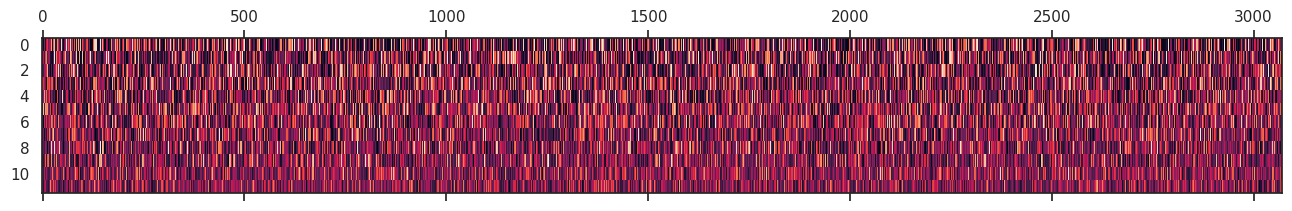

In [127]:
plt.matshow(auc_mat, aspect='auto')

In [128]:
top_neurons = [np.unravel_index(i, (12, 3072)) for i in np.argsort(auc_mat.flatten())][::-1]

In [129]:
top_neurons[:10]

[(2, 3017),
 (0, 1381),
 (0, 228),
 (0, 2710),
 (0, 1388),
 (7, 2870),
 (7, 439),
 (0, 1181),
 (0, 2317),
 (0, 2150)]

In [130]:
sorted(auc_mat.flatten())[::-1][10000]

0.6651157343296002

In [141]:
dist_df = pd.DataFrame([l for l, n in top_neurons[:10000]], columns=['Confounding Neurons'])

In [131]:
label_vec_size = int(scores.shape[0])

In [132]:
topic_labels = np.concatenate([np.zeros(label_vec_size), np.ones(label_vec_size)])

In [133]:
auc_mat_det = np.zeros((12, 3072))
for layer in range(12):
    for layer_neuron in tqdm(range(3072)):
        logits = scores_all[:, layer, :, layer_neuron]
        logits = logits.max(axis=1)
        # logits = np.maximum(logits, 0)
        auc = average_precision_score(topic_labels, logits)
        auc_mat_det[layer, layer_neuron] = auc

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3072/3072 [00:02<00:00, 1099.86it/s]


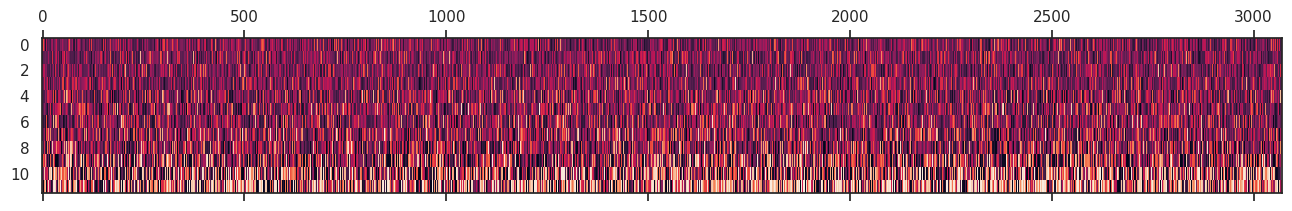

In [134]:
plt.matshow(auc_mat_det, aspect='auto')

In [135]:
top_neurons_det = [np.unravel_index(i, (12, 3072)) for i in np.argsort(auc_mat_det.flatten())][::-1]

In [28]:
top_neurons_det[:10]

[(10, 2664),
 (11, 287),
 (11, 1599),
 (10, 3069),
 (11, 1623),
 (11, 3052),
 (11, 1053),
 (11, 2226),
 (11, 1097),
 (11, 1093)]

In [73]:
sorted(auc_mat_det.flatten())[::-1][-1]

0.30934656951817574

In [30]:
auc_mat[2, 892]

0.37882030920403925

In [31]:
auc_mat_det[2, 892]

0.4042882418998776

In [32]:
auc_mat[3, 677]

0.395708843793687

In [33]:
auc_mat_det[3, 677]

0.693820236522201

In [34]:
[np.unravel_index(i, (12, 3072)) for i, auc in enumerate(auc_mat.flatten()) if auc>0.6 and auc_mat_det.flatten()[i]<0.05]

[]

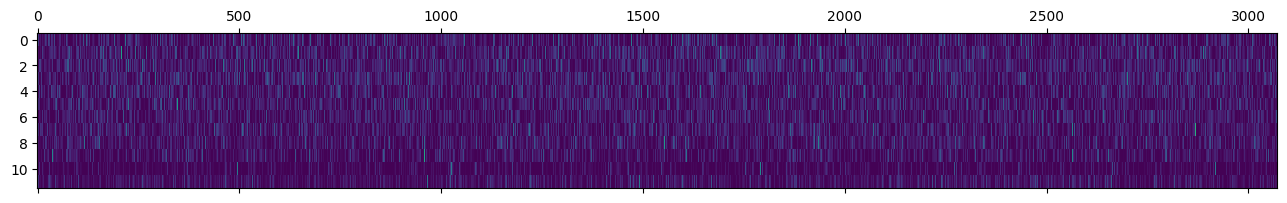

In [36]:
plt.matshow(np.max(scores_all, axis=(0, 2)), aspect='auto')

In [37]:
top_neurons_acts = [np.unravel_index(i, (12, 3072)) for i in np.argsort(np.max(scores_all, axis=(0, 2)).flatten())][::-1]

In [38]:
top_neurons_acts[:10]

[(9, 716),
 (7, 2870),
 (8, 2994),
 (9, 960),
 (7, 1283),
 (2, 2259),
 (1, 209),
 (5, 348),
 (8, 1554),
 (7, 1399)]

In [142]:
dist_df['Detection Neurons'] = [l for l, n in top_neurons_det[:10000]]

In [145]:
dist_df.value_counts().reset_index()

,Confounding Neurons,Detection Neurons,count
0,0,11,278
1,1,11,208
2,2,11,184
3,3,11,180
4,4,11,177
...,...,...,...
139,1,1,26
140,0,0,25
141,9,0,24
142,3,3,24


In [170]:
x, y = np.unique([l for l, n in top_neurons[:500]], return_counts=True)

In [171]:
xdet, ydet = np.unique([l for l, n in top_neurons_det[:500]], return_counts=True)

In [172]:
cseries = pd.Series({l: c for l, c in zip(x, y)})
cseriesdet = pd.Series({l: c for l, c in zip(xdet, ydet)})
# cseriesbsl = pd.Series({l: c for l, c in zip(xbsl, ybsl)})

In [173]:
countdf = pd.concat([cseries, cseriesdet], axis=1)

In [174]:
countdf.fillna(0., inplace=True)

In [175]:
countdf = countdf/countdf.sum(axis=0)

In [176]:
countdf.index+=1

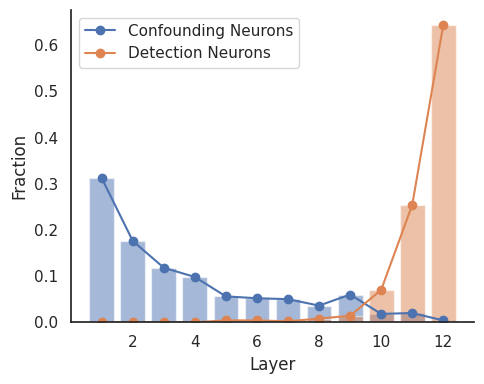

In [177]:
fig, ax = plt.subplots(figsize=(5, 4))
countdf.sort_index().plot(marker='o', ax=ax)
ax.bar(countdf.index, countdf[0], alpha=.5)
ax.bar(countdf.index, countdf[1], alpha=.5)
# ax.bar(countdf.index, countdf[2], alpha=.3)
ax.set_xlabel('Layer')
ax.set_ylabel('Fraction')
plt.legend(['Confounding Neurons', 'Detection Neurons'])
sb.despine()
plt.tight_layout()
plt.savefig(f'../figs/layer_distribution_{DATASET_NAME}_{EXPERIMENT_NAME}_rs_{random_state}_acts_linprobe.pdf')
plt.savefig(f'../figs/layer_distribution_{DATASET_NAME}_{EXPERIMENT_NAME}_rs_{random_state}_acts_linprobe.png')

In [212]:
ap_scores_dist = pd.Series(sorted(auc_mat.flatten(), reverse=True))

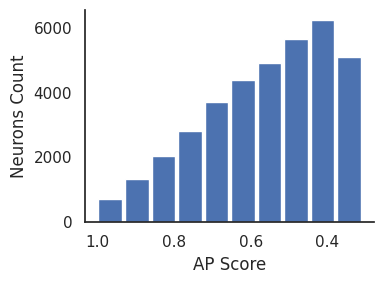

In [226]:
fig, ax = plt.subplots(figsize=(4, 3))
ap_scores_dist.plot.hist(ax=ax, rwidth=.9)
# ax.bar(countdf.index, countdf[2], alpha=.3)
ax.xaxis.set_inverted(True)
ax.set_xlabel('AP Score')
ax.set_ylabel('Neurons Count')
# plt.legend(['Confounding Neurons', 'Detection Neurons'])
sb.despine()
plt.tight_layout()
plt.savefig(f'../figs/ap_distribution_{DATASET_NAME}_{EXPERIMENT_NAME}_rs_{random_state}_acts_linprobe.pdf')
# plt.savefig(f'../figs/layer_distribution_{DATASET_NAME}_{EXPERIMENT_NAME}_rs_{random_state}_acts_linprobe.png')

In [263]:
ap_scores_dist.describe()

count    36864.000000
mean         0.561369
std          0.165991
min          0.309347
25%          0.425011
50%          0.536117
75%          0.679624
max          1.000000
dtype: float64

In [264]:
ap_scores_dist.quantile(0.9)

0.8045787444215033

# Compute accuracy

In [39]:
len(top_neurons)

36864

In [112]:
results_cm_all = []

In [41]:
inspector = load_model(f"../models/{MODEL_DICT_ID}/")
results_cm = [0]
# for df in [daigt_test, daigt_test_2, hc3_test]:
for df in [daigt_test_2, hc3_test, xsum_gpt_test]:
    y_pred, y_true = pred_true_labels(df, inspector)
    current_results = confusion_matrix(y_true, y_pred).flatten()
    results_cm.append(current_results)
    print(current_results)
results_cm_all.append(results_cm)

[436  64   4 496]
[279 221  18 482]
[361 139   6 494]


In [42]:
# top_neurons_tot = list(np.arange(51))
top_neurons_tot = [10, 50, 100, 500, 1000, 10000]
pbar = tqdm(top_neurons_tot)
for i in pbar:
    inspector = load_model(f"../models/{MODEL_DICT_ID}/")
    patch_suppress_enhance(inspector.model, neurons=top_neurons[:i+1])
    results_cm = [i+1]
    for j, df in enumerate([daigt_test_2, hc3_test, xsum_gpt_test]):
        y_pred, y_true = pred_true_labels(df, inspector)
        current_results = confusion_matrix(y_true, y_pred).flatten()
        results_cm.append(current_results)
        pbar.set_description(f"i: {i}, neur: {top_neurons[i]}, df: {j}, metrics {current_results}")
    results_cm_all.append(results_cm)
    # print(top_neurons[i], results_cm)

i: 10000, neur: (10, 512), df: 2, metrics [463  37  47 453]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [22:32<00:00, 225.41s/it]


In [43]:
cm_df = pd.DataFrame([np.concatenate(x[1:]) for x in results_cm_all]).reset_index()

In [44]:
cm_df.columns = ['removed', 
                 'tp_oos', 'fp_oos', 'fn_oos', 'tn_oos',
                 'tp_ood', 'fp_ood', 'fn_ood', 'tn_ood',
                 'tp_xsum', 'fp_xsum', 'fn_xsum', 'tn_xsum',
                ]

In [45]:
cm_df['removed'] = [0]+top_neurons_tot

In [46]:
# cm_df['TNR_is'] = cm_df['tn_is']/(cm_df['tn_is']+cm_df['fp_is'])
cm_df['TNR_oos'] = cm_df['tn_oos']/(cm_df['tn_oos']+cm_df['fp_oos'])
cm_df['TNR_ood'] = cm_df['tn_ood']/(cm_df['tn_ood']+cm_df['fp_ood'])
cm_df['TNR_xsum'] = cm_df['tn_xsum']/(cm_df['tn_xsum']+cm_df['fp_xsum'])

In [47]:
cm_df['TPR_oos'] = cm_df['tp_oos']/(cm_df['tp_oos']+cm_df['fn_oos'])
cm_df['TPR_ood'] = cm_df['tp_ood']/(cm_df['tp_ood']+cm_df['fn_ood'])
cm_df['TPR_xsum'] = cm_df['tp_xsum']/(cm_df['tp_xsum']+cm_df['fn_xsum'])

In [48]:
cm_df['ACC_oos'] = (cm_df['tp_oos']+cm_df['tn_oos'])/(cm_df['tp_oos']+cm_df['tn_oos']+cm_df['fp_oos']+cm_df['fn_oos'])
cm_df['ACC_ood'] = (cm_df['tp_ood']+cm_df['tn_ood'])/(cm_df['tp_ood']+cm_df['tn_ood']+cm_df['fp_ood']+cm_df['fn_ood'])
cm_df['ACC_xsum'] = (cm_df['tp_xsum']+cm_df['tn_xsum'])/(cm_df['tp_xsum']+cm_df['tn_xsum']+cm_df['fp_xsum']+cm_df['fn_xsum'])

In [63]:
cm_df.set_index('removed', inplace=True)

In [53]:
cm_df['neurons'] = ["None"]+[top_neurons[i] for i in top_neurons_tot]

In [70]:
cm_df.to_csv(f'../data/patching_scores_{DATASET_NAME}_{EXPERIMENT_NAME}_rs_{random_state}_acts_linprobe.csv')

In [54]:
cm_df

,removed,tp_oos,fp_oos,fn_oos,tn_oos,tp_ood,fp_ood,fn_ood,tn_ood,tp_xsum,...,TNR_oos,TNR_ood,TNR_xsum,TPR_oos,TPR_ood,TPR_xsum,ACC_oos,ACC_ood,ACC_xsum,neurons
0,0,436,64,4,496,279,221,18,482,361,...,0.885714,0.685633,0.780411,0.990909,0.939394,0.983651,0.932,0.761,0.855,None
1,10,436,64,4,496,279,221,18,482,359,...,0.885714,0.685633,0.777953,0.990909,0.939394,0.983562,0.932,0.761,0.853,"(3, 287)"
2,50,436,64,5,495,279,221,18,482,362,...,0.885510,0.685633,0.781646,0.988662,0.939394,0.983696,0.931,0.761,0.856,"(2, 2997)"
3,100,437,63,7,493,281,219,18,482,362,...,0.886691,0.687589,0.781646,0.984234,0.939799,0.983696,0.930,0.763,0.856,"(8, 755)"
4,500,442,58,8,492,295,205,19,481,373,...,0.894545,0.701166,0.794830,0.982222,0.939490,0.979003,0.934,0.776,0.865,"(1, 1982)"
5,1000,442,58,7,493,299,201,22,478,374,...,0.894737,0.703976,0.796446,0.984410,0.931464,0.981627,0.935,0.777,0.867,"(4, 652)"
6,10000,477,23,25,475,370,130,48,452,463,...,0.953815,0.776632,0.924490,0.950199,0.885167,0.907843,0.952,0.822,0.916,"(10, 512)"


In [96]:
cm_df = pd.read_csv(f'../data/patching_scores_{DATASET_NAME}_{EXPERIMENT_NAME}_rs_{random_state}_acts_linprobe.csv', index_col=0)

In [99]:
gain_df = 100*(cm_df-cm_df.iloc[0]).copy()

In [181]:
idx = gain_df.index.tolist()

In [182]:
idx[0]+=1

In [183]:
gain_df.index = idx

In [184]:
sb.set_theme(context='notebook', style="white")

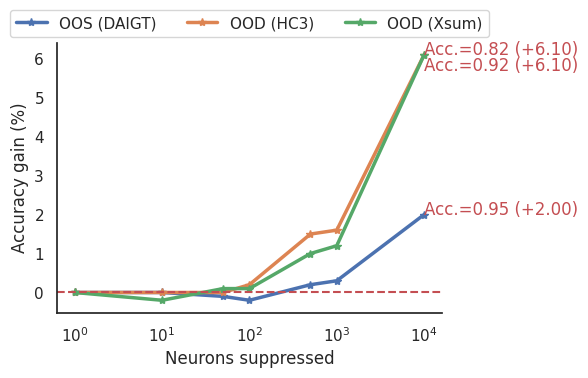

In [203]:
fig, ax = plt.subplots(figsize=(6, 4))
gain_df[['ACC_oos', 'ACC_ood', 'ACC_xsum']].plot(style='*-', ax=ax, lw=2.5)
# for lc, col in zip(['b', 'darkorange', 'g'], ['ACC_oos', 'ACC_ood', 'ACC_xsum']):
#     sb.lineplot(data=gain_rnd_df, x='removed', y=col, errorbar=('sd', 1), ax=ax, color=lc)
plt.axhline(0., c='r', ls='--')
# plt.title(f"{EXPERIMENT_NAME} \n {TOPICS_ANALYSIS}")
plt.xlabel('Neurons suppressed')
plt.ylabel('Accuracy gain (%)')
plt.legend(['OOS (DAIGT)', 'OOD (HC3)', 'OOD (Xsum)'], loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=3)
# for col in ['ACC_oos', 'ACC_ood', 'ACC_xsum']:
plt.text(gain_df.index[-1]+1, gain_df['ACC_oos'].iloc[-1], f"Acc.={cm_df['ACC_oos'].iloc[-1]:.2f} (+{gain_df['ACC_oos'].iloc[-1]:.2f})", c='r')
plt.text(gain_df.index[-1]+1, gain_df['ACC_ood'].iloc[-1]+0., f"Acc.={cm_df['ACC_ood'].iloc[-1]:.2f} (+{gain_df['ACC_ood'].iloc[-1]:.2f})", c='r')
plt.text(gain_df.index[-1]+1, gain_df['ACC_xsum'].iloc[-1]-0.4, f"Acc.={cm_df['ACC_xsum'].iloc[-1]:.2f} (+{gain_df['ACC_xsum'].iloc[-1]:.2f})", c='r')
# for col in ['ACC_oos', 'ACC_ood', 'ACC_xsum']:
#     plt.text(-2, cm_df.loc[0, col]+0.005, f"{cm_df.loc[0, col]:.2f}", c='grey')
plt.xscale('log')
sb.despine()
plt.tight_layout()
plt.savefig(f"../figs/acc_gain_{DATASET_NAME}_{EXPERIMENT_NAME}_rs_{random_state}_acts_linprobe.pdf")